In [1]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import shutil
import warnings
import pandas as pd
import time
import random
import tensorflow as tf

In [2]:
SAVED_MODEL = "C:/Users/noppa/Desktop/I-NewGen/System/Project/try/unet/best_model"

In [3]:
unet = tf.keras.models.load_model(SAVED_MODEL)

In [5]:
image_path = "C:/Users/noppa/Desktop/I-NewGen/System/Project/image_path/preprocessed_image2.jpg"

In [8]:
IMAGE_SIZE = 512

In [6]:
#image_path ตำแหน่งภาพ
def read_image(image_path, mask=False):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, channels=1)
  base_image = image
  image.set_shape([None, None, 1])
  if mask:
    image = tf.cast(image, dtype=tf.int32)
    return image
  else:
    image = tf.cast(image, dtype=tf.float32)
    image = image / 127.5 - 1
    return image, base_image

In [9]:
def normalize(image):
  image = image[:, 540:1620]
  image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
  return image

In [11]:
def infer(model, image_tensor):
  mask, values = model.predict(np.expand_dims((image_tensor), axis=0), verbose=0)
  mask = np.squeeze(mask)
  mask_npy = np.argmax(mask, axis=2).astype(np.uint8)
  mask = tf.convert_to_tensor(mask_npy)

  predictions = {
    "image": image_tensor,
    "mask": mask,
    "x": int(values[0][0] * 1080) + 420,
    "y": int(values[0][1] * 1080),
    "angle": values[0][2] * 180 if len(values[0]) > 2 else 0,  # แก้ไขเพื่อรองรับกรณีไม่มี angle
    "type": "predicted"
}


  return predictions

In [12]:
def plot_visualization(real_data, predicted_data):
  colors = {"background":[59, 82, 139],
            "arm":[3, 31, 254],
            "veins":[253, 231, 37]}

  visualization = []
  image = real_data["image"].numpy().astype(np.uint8)
  image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  for data in [real_data,
               predicted_data
               ]:
    mask = data["mask"].numpy().astype(np.uint8)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    mask[np.where((mask==[0,0,0]).all(axis=2))] = colors["background"]
    mask[np.where((mask==[1,1,1]).all(axis=2))] = colors["arm"]
    mask[np.where((mask==[2,2,2]).all(axis=2))] = colors["veins"]

    if data["type"] == "predicted":
      mask = cv2.resize(mask, (1080,1080), interpolation = cv2.INTER_AREA)
      final_mask = np.full(shape = (1080,1920,3), fill_value=colors["background"])
      final_mask[:,540:1620,:] = mask
      mask = final_mask.astype(np.uint8)

    new_image = cv2.addWeighted(image, 0.8, mask, 0.5, 0.0)
    angle = data["angle"]
    cv2.circle(new_image, (data["x"], data["y"]), radius=10, color=(0,255,0), thickness=-1)
    cv2.putText(new_image, f"{angle:.2f}", (data["x"]+10,data["y"]+5), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,255,0), thickness = 5)
    visualization.append(new_image)

    # Preprocessing
    new_image2 = cv2.addWeighted(image, 0.8, mask, 0.5, 0.0)
    size = 100
    start_point = (data["x"]-int(size/2), data["y"]-int(size/2))
    end_point = (data["x"]+int(size/2), data["y"]+int(size/2))
    new_image2 = cv2.rectangle(new_image2, start_point, end_point, (0,255,0), 5)
    visualization.append(new_image2)
    cv2.imshow("Inference", cv2.cvtColor(new_image2, cv2.COLOR_BGR2RGB))
    cv2.waitKey(0)
    cv2.destroyAllWindows()


  f, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(12, 7))

  ax[0][0].set_title("Real")
  ax[0][0].imshow(visualization[0])
  ax[0][1].set_title("Predicted")
  ax[0][1].imshow(visualization[2])
  ax[1][0].imshow(visualization[1])
  ax[1][1].imshow(visualization[3])

In [13]:
def make_prediction(model):
  random_sample = random.randint(0, len(test_images)-1)
  id = test_ids[random_sample]

  image = test_images[random_sample]
  image_tensor, base_image_tensor = read_image(image)

  mask = test_masks[random_sample]
  mask_tensor = read_image(mask, mask=True)
  real_data = {"image": base_image_tensor,
               "mask": mask_tensor,
               "x":test_acf_x_centers[random_sample],
               "y":test_acf_y_centers[random_sample],
               "angle":test_angles[random_sample],
               "type":"real"}

  image_tensor = normalize(image_tensor)
  predicted_data = infer(model=model, image_tensor=image_tensor)
  plot_visualization(real_data, predicted_data)
  print("preprocessed_image:", dataset.at[id, "preprocessed_image"])

In [16]:
def make_prediction(model):
  # ใช้ภาพที่กำหนดไว้แทนการสุ่ม
  image_path = "C:/Users/noppa/Desktop/I-NewGen/System/Project/image_path/preprocessed_image2.jpg"
  
  # โหลดภาพที่กำหนด
  image_tensor, base_image_tensor = read_image(image_path)

  # แทนที่การโหลด mask ด้วยค่าปลอม (เนื่องจากไม่มีข้อมูล mask จริง)
  mask_tensor = tf.zeros_like(base_image_tensor)  # สร้าง mask เปล่า

  # กำหนดค่าปลอมสำหรับข้อมูลจริง
  real_data = {
      "image": base_image_tensor,
      "mask": mask_tensor,
      "x": 0,  # ค่าปลอม
      "y": 0,  # ค่าปลอม
      "angle": 0,  # ค่าปลอม
      "type": "real"
  }

  # ปรับขนาดภาพให้ตรงกับ input ของโมเดล
  image_tensor = normalize(image_tensor)

  # ทำการพยากรณ์ด้วยโมเดล
  predicted_data = infer(model=model, image_tensor=image_tensor)

  # แสดงผลลัพธ์
  plot_visualization(real_data, predicted_data)

  # พิมพ์ชื่อไฟล์ที่ใช้พยากรณ์
  print("preprocessed_image:", image_path)


preprocessed_image: C:/Users/noppa/Desktop/I-NewGen/System/Project/image_path/preprocessed_image2.jpg


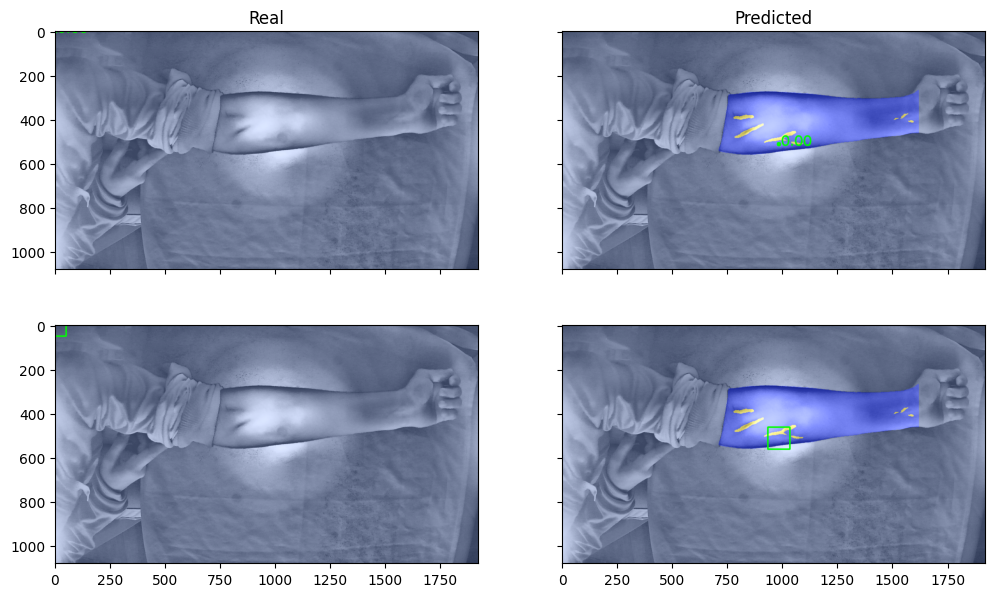

In [17]:
make_prediction(unet)